In [1]:
import tensorflow as tf
from tensorflow import keras 
print(tf.__version__)
print(keras.__version__)

2.7.0
2.7.0


In [138]:
# # Make sure the GPU is availalbe 
# import tensorflow as tf
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#     raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))

In [92]:
import segmentation_models_3D as sm

In [93]:
from skimage import io
from patchify import patchify, unpatchify
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
# from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical

In [97]:
image = io.imread(r'C:\Users\MI2RL-KHJ\adni_project\dataset\003_S_0981_2011-01-04\PAD\rs_MRI_003_S_0981_2011-01-04.nii')
mask = io.imread(r'C:\Users\MI2RL-KHJ\adni_project\dataset\003_S_0981_2011-01-04\PAD\rs_PET_003_S_0981_2011-01-04.nii')

In [98]:
image.shape, mask.shape

((256, 256, 256), (256, 256, 256))

In [99]:
# Consider Whether to use patch or not
img_patches = patchify( image, (64, 64, 64), step=64)  # Step6=64 for 64 pathces means no overlap
mask_patches = patchify(mask, (64,64,64), step=64)

In [100]:
print(img_patches.shape), print(image.shape)

(4, 4, 4, 64, 64, 64)
(256, 256, 256)


(None, None)

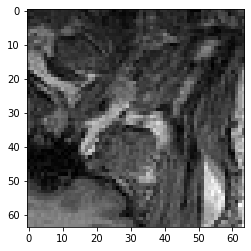

In [101]:
plt.imshow(img_patches[1,2,1,:,:,32], cmap='gray')

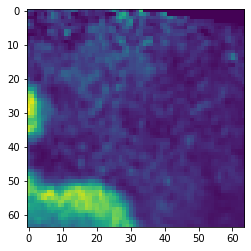

In [102]:
plt.imshow(mask_patches[1,2,1,:,:,32])

In [114]:
input_img = np.reshape(img_patches, (-1, img_patches.shape[3], img_patches.shape[4], img_patches.shape[5]))
input_mask = np.reshape(mask_patches, (-1, mask_patches.shape[3], mask_patches.shape[4], mask_patches.shape[5]))
                        
print(input_img.shape) # n_pathces, x, y, z

(64, 64, 64, 64)


In [115]:
n_classes = 4

In [116]:
train_mask.shape

(64, 64, 64, 64, 1)

In [117]:
# Convert gray image to 3 channels by copying channel 3 times. 
# We do this as our unet more expect 3 channel 1 input 

train_img = np.stack((input_img, )*3, axis=-1) #64*64*64*3
train_mask = np.expand_dims(input_mask, axis=4) #(?mask = 1d???)

# 써야되는지 고민하기 - 일단 써라 -> 나중에 relu를 써서 값을 가리면 됨 
train_mask_part1 = to_categorical(train_mask, num_classes=n_classes)#n_classes)

# 차후 Validation set 고려해보기 
X_train, X_test, y_train, y_test = train_test_split(train_img, train_mask_part1, test_size = 0.20, random_state=123)

IndexError: index 44 is out of bounds for axis 1 with size 4

In [121]:
# loss Function and Coefficients to be used during training:
def dice_coefficient(y_true, y_pred):
    smoothing_factor = 1
    flat_y_true = K.flatten(y_true)
    flat_y_pred = K.flatten(y_pred)
    return (2. * K.sum(flat_y_true *flat_y_pred) + smoothing_factor)/ (K.sum(flat_y_true)+K.sum(flat_y_pred))

def dice_coefficient_loss(y_true, y_pred):
    return 1-dice_coeffcienct(y_true, y_pred)


### 

## Backbone

In [122]:
# Define parameters for our model. 

encoder_weights = 'imagenet' #if it is a  good baseline
BACKBONE = 'vgg16' # Try vgg16, efficientnetb7, inceptionv3, resnet50
activation = 'relu' #softmax #linear;regression #'softmax'; classification
patch_size = 64
n_classes = 4 # 256
channels = 3 #dimension

LR = 0.0001
optim = tf.keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# Set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss(class_weights=np.array([0., 1., 1., 1.])) #[0.25, 0.25, 0.25, 0.25]
focal_loss = sm.losses.CategoricalFocalLoss() #imbalance - 
total_loss = dice_loss + (1 * focal_loss)

# actually total_loss can be imported directly from library, above example just show you how to manipulate 
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

In [123]:
preprocess_intput = sm.get_preprocessing(BACKBONE) #preprocessing => normalizing, scaling 

In [124]:
## Preprocess input data - otherwise you end up with garbate reuslts  #normalizing->scale, ~~etc.
# and potentially model does not converge.
X_train_prep = preprocess_intput(X_train)
X_test_prep = preprocess_intput(X_test)

In [125]:
# Define the model. Here we use Unet but we can also use other model architectures from library.
model = sm.Unet(BACKBONE, classes = n_classes, 
                input_shape=(patch_size, patch_size, patch_size, channels),
                encoder_weights=encoder_weights,
                activation = activation)

model.compile(optimizer=optim, loss=total_loss, metrics=metrics)
print(model.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 64, 64, 64,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv3D)          (None, 64, 64, 64,   5248        ['input_3[0][0]']                
                                64)                                                               
                                                                                                  
 block1_conv2 (Conv3D)          (None, 64, 64, 64,   110656      ['block1_conv1[0][0]']           
                                64)                                                         

In [127]:
# Fit the model 
history = model.fit(X_train_prep,
                   y_train,
                   batch_size=9, 
                   epochs=10,
                   verbose=1,
                   validation_data=(X_test_prep, y_test))

# remember 
# batch_isze = 8 -> 9


Epoch 1/10
2/2 [==============================] - 151s 56s/step - loss: 1.0028 - iou_score: 0.2441 - f1-score: 0.2470 - val_loss: 1.0050 - val_iou_score: 0.2325 - val_f1-score: 0.2409
Epoch 2/10
2/2 [==============================] - 150s 56s/step - loss: 1.0024 - iou_score: 0.2441 - f1-score: 0.2470 - val_loss: 1.0048 - val_iou_score: 0.2320 - val_f1-score: 0.2407
Epoch 3/10
2/2 [==============================] - 151s 55s/step - loss: 1.0019 - iou_score: 0.2454 - f1-score: 0.2477 - val_loss: 1.0046 - val_iou_score: 0.2320 - val_f1-score: 0.2406
Epoch 4/10
2/2 [==============================] - 149s 55s/step - loss: 1.0016 - iou_score: 0.2453 - f1-score: 0.2476 - val_loss: 1.0046 - val_iou_score: 0.2317 - val_f1-score: 0.2405
Epoch 5/10
2/2 [==============================] - 150s 55s/step - loss: 1.0014 - iou_score: 0.2456 - f1-score: 0.2478 - val_loss: 1.0045 - val_iou_score: 0.2319 - val_f1-score: 0.2406
Epoch 6/10
2/2 [==============================] - 152s 56s/step - loss: 1.0011 -

In [128]:
model.save(os.path.join(path, '3D_model_vgg16_10epochs_20211215.h5'))

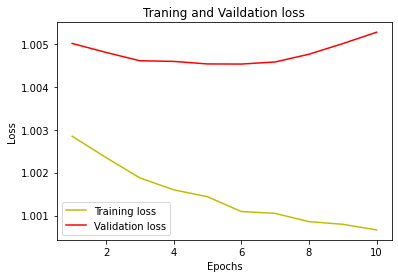

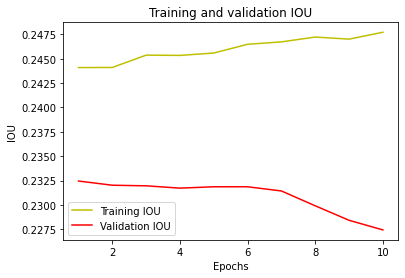

In [129]:
###
# plot the traning and validation IoU and loss at each epoch

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs,   loss, 'y', label='Training loss')
plt.plot(epochs,   val_loss, 'r', label='Validation loss')
plt.title('Traning and Vaildation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

In [130]:
# Load the pretrained model for testing and predictions 
from keras.models import load_model
my_model = load_model(os.path.join(path, '3D_model_vgg16_10epochs.h5'), compile=False)
# If you lad a different model, do not forget to preprocess accordingly .

In [131]:
# Predict on the test data
y_pred = my_model.predict(X_test)
y_pred_argmax = np.argmax(y_pred)#, axis=4)
y_test_argmax = np.argmax(y_test)#, axis=4)

#### 나혼자 해보기

In [132]:
y_pred

array([[[[[0.00000000e+00, 0.00000000e+00, 4.14148755e-02,
           0.00000000e+00],
          [0.00000000e+00, 8.81125592e-03, 0.00000000e+00,
           0.00000000e+00],
          [0.00000000e+00, 2.03356091e-02, 0.00000000e+00,
           0.00000000e+00],
          ...,
          [0.00000000e+00, 2.60134623e-03, 0.00000000e+00,
           8.72475281e-03],
          [0.00000000e+00, 0.00000000e+00, 2.04245076e-02,
           2.43467186e-03],
          [0.00000000e+00, 1.17675327e-01, 9.49090272e-02,
           4.43111248e-02]],

         [[0.00000000e+00, 0.00000000e+00, 2.96378881e-02,
           5.27561642e-02],
          [0.00000000e+00, 7.87372217e-02, 0.00000000e+00,
           2.94183195e-03],
          [0.00000000e+00, 4.86288145e-02, 1.00401202e-02,
           0.00000000e+00],
          ...,
          [0.00000000e+00, 0.00000000e+00, 5.72492331e-02,
           3.82069834e-02],
          [0.00000000e+00, 0.00000000e+00, 7.99629763e-02,
           6.69489279e-02],
          [

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


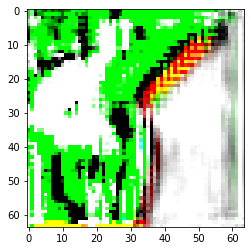

In [133]:
plt.imshow(y_pred[1,:,:,32], cmap='gray')

In [134]:
y_test.shape

(4, 64, 64, 64, 4)

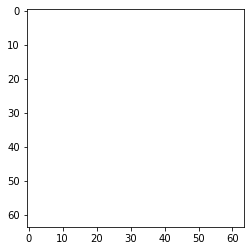

In [135]:
plt.imshow(y_test[1,:,:,45], cmap='gray')

In [136]:
y_pred

array([[[[[0.00000000e+00, 0.00000000e+00, 4.14148755e-02,
           0.00000000e+00],
          [0.00000000e+00, 8.81125592e-03, 0.00000000e+00,
           0.00000000e+00],
          [0.00000000e+00, 2.03356091e-02, 0.00000000e+00,
           0.00000000e+00],
          ...,
          [0.00000000e+00, 2.60134623e-03, 0.00000000e+00,
           8.72475281e-03],
          [0.00000000e+00, 0.00000000e+00, 2.04245076e-02,
           2.43467186e-03],
          [0.00000000e+00, 1.17675327e-01, 9.49090272e-02,
           4.43111248e-02]],

         [[0.00000000e+00, 0.00000000e+00, 2.96378881e-02,
           5.27561642e-02],
          [0.00000000e+00, 7.87372217e-02, 0.00000000e+00,
           2.94183195e-03],
          [0.00000000e+00, 4.86288145e-02, 1.00401202e-02,
           0.00000000e+00],
          ...,
          [0.00000000e+00, 0.00000000e+00, 5.72492331e-02,
           3.82069834e-02],
          [0.00000000e+00, 0.00000000e+00, 7.99629763e-02,
           6.69489279e-02],
          [

In [137]:
print(y_pred_argmax.shape)
print(y_test_argmax.shape)
print(np.unique(y_pred_argmax))

()
()
[967633]


##### ↑ 마지막 channel을 안줬을 때... 이런 이상한 결말이.. 애초에 categorical이 안되게 하려면? 
############################# 

In [74]:
# Predict on the test data
y_pred = my_model.predict(X_test)
y_pred_argmax = np.argmax(y_pred, axis=4)
y_test_argmax = np.argmax(y_test, axis=4)

In [75]:
print(y_pred_argmax.shape) #youtube (7, 64, 64, 64)
print(y_test_argmax.shape) #youtube (7, 64, 64, 64)
print(np.unique(y_pred_argmax)) #youtube: [2,3]

(4, 64, 64, 64)
(4, 64, 64, 64)
[0 1 2 3]


In [77]:
## Using built in keras function for IoU
# Only works onf TF > 2.0
from keras.metrics import MeanIoU
n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_test_argmax, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.02095747


In [85]:
# Test some random images
import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth = y_test[test_img_number]

test_img_input = np.expand_dims(test_img, 0)
test_img_input1 = preprocess_intput(test_img_input)

test_pred1 = my_model.predict(test_img_input1)
test_prediction1 = np.argmax(test_pred1, axis=4)[0,:,:,:]
print(test_prediction1.shape)

(64, 64, 64)


In [86]:
ground_truth_argmax =np.argmax(ground_truth, axis=3)
print(test_img.shape)

(64, 64, 64, 3)


NameError: name 'test_prediction' is not defined

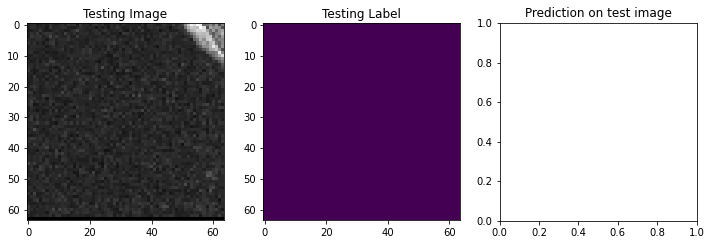

In [89]:
# Plot individual slices from test preidctions for verification
slice = 14
plt.figure(figsize=(12,8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[slice,:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth_argmax[slice,:,:])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction[slice,:,:])
plt.show()


In [ ]:
# Test some ra

In [29]:
image.argmax(), image.argmin()
image.resize

(2054963, 30560)